#Import library

In [60]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as _sum
import matplotlib.pyplot as plt
import os
import seaborn as sns

#Inisialisasi SparkSession

In [30]:
spark = SparkSession.builder \
    .appName("Airline Customer Data Analysis") \
    .getOrCreate()

#Load Dataset ke DataFrame

In [31]:
df_calendar = spark.read.option("header", True).csv("/content/calendar.csv")
df_flight = spark.read.option("header", True).csv("/content/customer_flight_activity.csv")
df_loyalty = spark.read.option("header", True).csv("/content/customer_loyalty_history.csv")

#Cek Schema dan Tipe Data

In [32]:
df_flight.printSchema()
df_flight.show(2)

root
 |-- _c0: string (nullable = true)
 |-- loyalty_number: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- total_flights: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- points_accumulated: string (nullable = true)
 |-- points_redeemed: string (nullable = true)
 |-- dollar_cost_points_redeemed: string (nullable = true)

+---+--------------+----+-----+-------------+--------+------------------+---------------+---------------------------+
|_c0|loyalty_number|year|month|total_flights|distance|points_accumulated|points_redeemed|dollar_cost_points_redeemed|
+---+--------------+----+-----+-------------+--------+------------------+---------------+---------------------------+
|  0|        100590|2018|    6|           12|   15276|           22914.0|              0|                          0|
|  1|        100590|2018|    7|           12|    9168|           13752.0|              0|                          0|
+---+----

In [33]:
df_loyalty.printSchema()
df_loyalty.show(2)

root
 |-- _c0: string (nullable = true)
 |-- loyalty_number: string (nullable = true)
 |-- country: string (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- education: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- loyalty_card: string (nullable = true)
 |-- customer_lifetime_value: string (nullable = true)
 |-- enrollment_type: string (nullable = true)
 |-- enrollment_year: string (nullable = true)
 |-- enrollment_month: string (nullable = true)
 |-- cancellation_year: string (nullable = true)
 |-- cancellation_month: string (nullable = true)

+---+--------------+-------+--------+--------+-----------+------+---------+-------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|_c0|loyalty_number|country|pr

#Cast tipe data ke tipe yang sesuai

In [34]:
df_flight = df_flight.withColumn("year", col("year").cast("int")) \
    .withColumn("month", col("month").cast("int")) \
    .withColumn("total_flights", col("total_flights").cast("int")) \
    .withColumn("distance", col("distance").cast("double")) \
    .withColumn("points_accumulated", col("points_accumulated").cast("int")) \
    .withColumn("points_redeemed", col("points_redeemed").cast("int")) \
    .withColumn("dollar_cost_points_redeemed", col("dollar_cost_points_redeemed").cast("double"))

In [35]:
df_loyalty = df_loyalty.withColumn("salary", col("salary").cast("double")) \
    .withColumn("enrollment_year", col("enrollment_year").cast("int")) \
    .withColumn("enrollment_month", col("enrollment_month").cast("int")) \
    .withColumn("cancellation_year", col("cancellation_year").cast("int")) \
    .withColumn("cancellation_month", col("cancellation_month").cast("int"))

#Data Cleaning

##Handle missing values

In [36]:
df_flight = df_flight.dropna(subset=["loyalty_number", "year", "total_flights"])
df_loyalty = df_loyalty.fillna({"education": "Unknown", "loyalty_card": "Unknown"})

##Hapus data duplikat

In [37]:
df_flight = df_flight.dropDuplicates()
df_loyalty = df_loyalty.dropDuplicates()

#Transformasi Data

##Join tables on loyalty_number

In [38]:
df_joined = df_flight.join(df_loyalty, on="loyalty_number", how="left")

#Register temp view for SQL queries

In [39]:
df_joined.createOrReplaceTempView("customer_data")
df_joined.createOrReplaceTempView("customer_data")

##Query 1: Average flights per customer per year


In [40]:
avg_flights = spark.sql("""
    SELECT year, AVG(total_flights) AS avg_flights_per_customer
    FROM customer_data
    GROUP BY year
    ORDER BY year
""")
avg_flights.show()

+----+------------------------+
|year|avg_flights_per_customer|
+----+------------------------+
|2017|      1.1682993197278913|
|2018|      1.4147426623595394|
+----+------------------------+



##Query 2: Loyalty points distribution by loyalty card status

In [41]:
loyalty_points_dist = spark.sql("""
    SELECT loyalty_card, AVG(points_accumulated) AS avg_points
    FROM customer_data
    GROUP BY loyalty_card
    ORDER BY avg_points DESC
""")
loyalty_points_dist.show()

+------------+------------------+
|loyalty_card|        avg_points|
+------------+------------------+
|      Aurora|2034.4787753035187|
|        Nova|2025.2811661921467|
|        Star|2003.5931976297659|
+------------+------------------+



##Query 3: Relation between education level and average flights

In [42]:
education_flights = spark.sql("""
    SELECT education, AVG(total_flights) AS avg_flights
    FROM customer_data
    GROUP BY education
    ORDER BY avg_flights DESC
""")
education_flights.show()

+--------------------+------------------+
|           education|       avg_flights|
+--------------------+------------------+
|High School or Below|1.3204052729055453|
|             College| 1.302957866720233|
|            Bachelor|1.2913346694692933|
|              Master| 1.288361320208454|
|              Doctor|1.2764908256880734|
+--------------------+------------------+



##Query 4: Flight trend over years

In [43]:
flights_trend = spark.sql("""
    SELECT year, SUM(total_flights) AS total_flights
    FROM customer_data
    GROUP BY year
    ORDER BY year
""")
flights_trend.show()

+----+-------------+
|year|total_flights|
+----+-------------+
|2017|       223262|
|2018|       285546|
+----+-------------+



# Visualisasi hasil dengan matplotlib

In [44]:
os.makedirs("visualizations", exist_ok=True)

##Konversi ke pandas

In [45]:
avg_flights_pd = avg_flights.toPandas()
loyalty_points_pd = loyalty_points_dist.toPandas()
education_flights_pd = education_flights.toPandas()
flights_trend_pd = flights_trend.toPandas()

##Grafik 1: line chart Rata-rata penerbangan per pelanggan per tahun

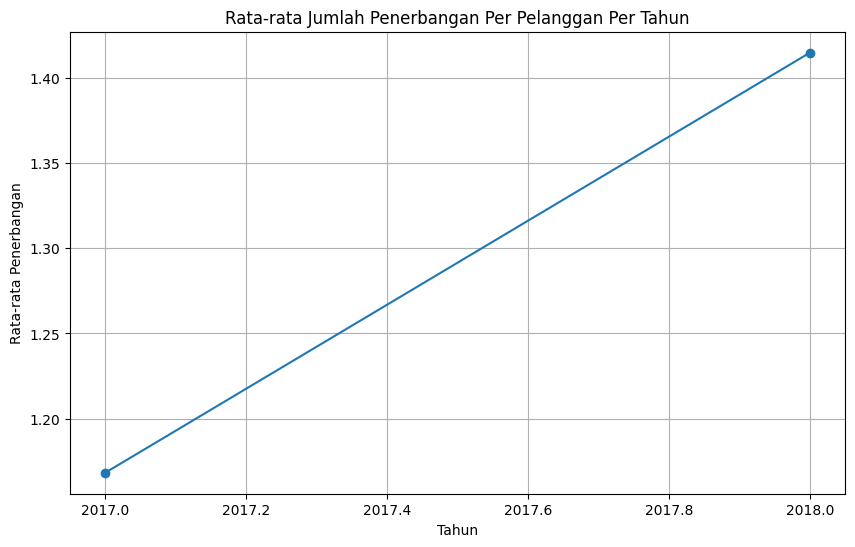

In [46]:
plt.figure(figsize=(10,6))
plt.plot(avg_flights_pd['year'], avg_flights_pd['avg_flights_per_customer'], marker='o')
plt.title("Rata-rata Jumlah Penerbangan Per Pelanggan Per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Penerbangan")
plt.grid(True)
plt.savefig("visualizations/avg_flights_per_year.png")
plt.show()

##Grafik 2: Pie Chart Distribusi Pelanggan per Status Kartu Loyalitas

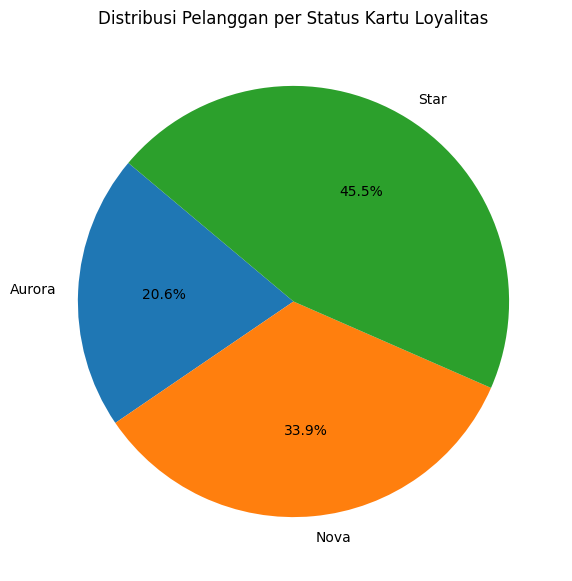

In [59]:
df_pie = df_joined.groupBy("loyalty_card").count().toPandas()
plt.figure(figsize=(7,7))
plt.pie(df_pie['count'], labels=df_pie['loyalty_card'], autopct='%1.1f%%', startangle=140)
plt.title("Distribusi Pelanggan per Status Kartu Loyalitas")
plt.savefig("visualizations/pie_loyalty_card_distribution.png")
plt.show()

##Grafik 3: Bar Chart Rata-rata penerbangan berdasarkan tingkat pendidikan

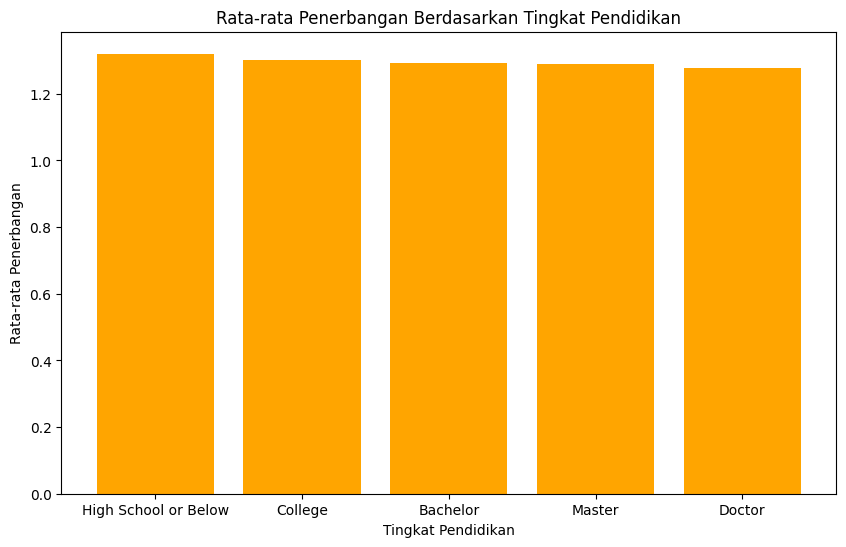

In [48]:
plt.figure(figsize=(10,6))
plt.bar(education_flights_pd['education'], education_flights_pd['avg_flights'], color='orange')
plt.title("Rata-rata Penerbangan Berdasarkan Tingkat Pendidikan")
plt.xlabel("Tingkat Pendidikan")
plt.ylabel("Rata-rata Penerbangan")
plt.savefig("visualizations/avg_flights_by_education.png")
plt.show()

##Grafik 4: Heatmap Tren Penerbangan per Bulan dan Tahun

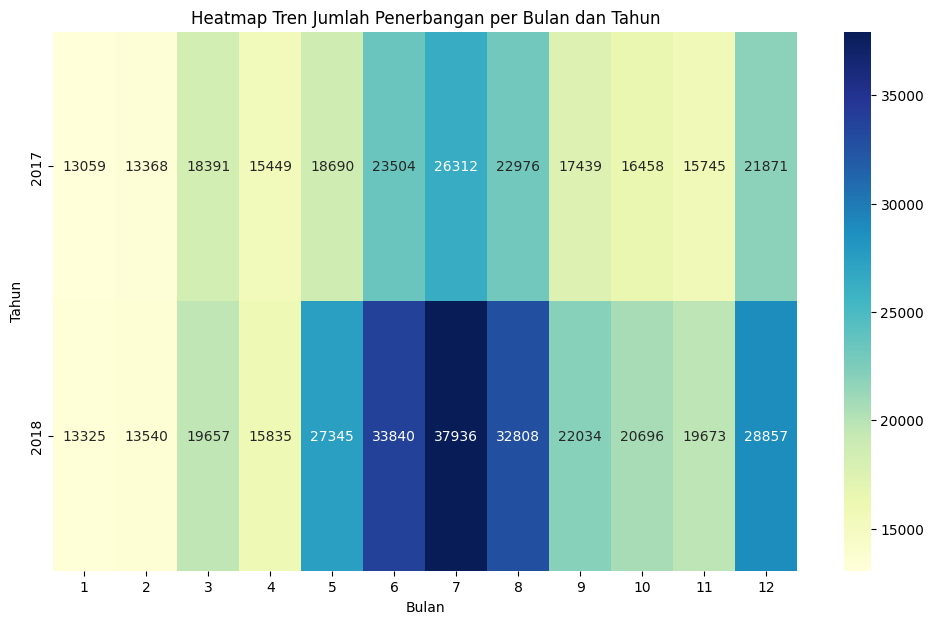

In [61]:
agg_month_year = df_joined.groupBy("year", "month") \
    .sum("total_flights") \
    .withColumnRenamed("sum(total_flights)", "total_flights") \
    .toPandas()
pivot_heatmap = agg_month_year.pivot(index='year', columns='month', values='total_flights').fillna(0)
plt.figure(figsize=(12,7))
sns.heatmap(pivot_heatmap, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Heatmap Tren Jumlah Penerbangan per Bulan dan Tahun")
plt.xlabel("Bulan")
plt.ylabel("Tahun")
plt.savefig("visualizations/heatmap_flights_month_year.png")
plt.show()

#Simpan hasil analisis ke CSV

In [50]:
os.makedirs("output", exist_ok=True)

In [51]:
avg_flights.write.mode("overwrite").csv("output/avg_flights_per_year.csv", header=True)
loyalty_points_dist.write.mode("overwrite").csv("output/avg_points_loyalty_card.csv", header=True)
education_flights.write.mode("overwrite").csv("output/avg_flights_by_education.csv", header=True)
flights_trend.write.mode("overwrite").csv("output/total_flights_trend.csv", header=True)

#Akhiri SparkSession

In [27]:
spark.stop()